### LightGBMを試す


In [1]:
import numpy as np
import pandas as pd
import gc
import os
import time
import random
from tqdm.auto import tqdm
import datetime
import dask.dataframe as dd

In [2]:
def visualize_df(df):
    print(df.shape)
    display(df.head())

## Read Data

In [3]:
input_type = {
 'customer_id':                 'int64',
 'article_id':                  'int32',
 'label':                       'bool',
 'FN':                          'bool',
 'Active':                      'bool',
 'club_member_status':          'int8',
 'fashion_news_frequency':      'int8',
 'age':                         'int8',
 'a_mean_age':                  'int8',
 'a_std_age':                   'float16',
 'postal_code':                 'int32',   
 'product_code':                'int32',  
 'product_type_no':             'int32',
 'graphical_appearance_no':     'int32',
 'colour_group_code':           'int32',
 'perceived_colour_value_id':   'int32',
 'perceived_colour_master_id':  'int32',
 'department_no':               'int16',
 'index_code':                  'int16',
 'index_group_no':              'int8',
 'section_no':                  'int8',
 'garment_group_no':            'int16',
 'is_for_male':                 'bool',
 'is_for_female':               'bool',
 'is_for_mama':                 'bool',
 'c_mean_price':                'float16',
 'c_std_price':                 'float16',
 'a_mean_price':                'float16',     
 'c_cv_total':                  'int32',
 'a_cv_total':                  'int32', 
 'c_cv_recent':                 'int32',
 'a_cv_recent':                 'int32',
 'a_cv_recent2':                'int32',
 'a_cv_recent_ratio':           'float16',
 'a_cv_recent_ranking':         'int16',
 'a_cv_recent_ranking2':        'int16',
 'c_mean_sales_channel_id':     'float16',
 'a_mean_sales_channel_id':     'float16',
 'c_mean_is_for_male':          'float16',
 'a_mean_is_for_male':          'float16',
 'c_mean_is_for_female':        'float16',
 'a_mean_is_for_female':        'float16',
 'c_mean_is_for_mama':          'float16',
 'diff_dat_last_buy':           'int16',
 'a_mean_is_for_mama':          'float16',
 'ca_index_group_no_num':       'int32',
 'index_group_no_similarity':   'float32',
 'ca_index_code_num':           'int32',
 'index_code_similarity':       'float32',
 'ca_product_group_no_num':     'int32',
 'product_group_no_similarity': 'float32',
 'buy_same_before':             'int16',
 'buy_same_before_recent':      'int16',
 'buy_same_last_week':          'int16',
 'buy_rank1_before':             'int16',
 'buy_rank2_before':             'int16',
 'diff_dat_last_buy_rank1':      'int16',
 'diff_dat_last_buy_rank2':      'int16',
 'delta_mean_price':            'float16',
 'delta_mean_age':              'int8',
 'delta_mean_sales_channel_id': 'float16',
 'delta_mean_is_for_male':      'float16',
 'delta_mean_is_for_female':    'float16',
 'delta_mean_is_for_mama':      'float16',
 'match_rank':                  'int8',
 'als_rank':                    'int8',
 'match_len':                   'int8'
 }

In [4]:
# train data
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09', '2020-09-16']
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09']
#train_date_list = ['2020-09-09', '2020-09-16']
train_date_list = ['2020-09-09']
#train_date_list = ['2020-09-16']
train_list = [dd.read_csv(f'./train_{date}.csv', dtype=input_type).compute() for date in train_date_list]

In [5]:
train = pd.concat([train_list[0]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[2]], ignore_index=True)
#valid = train_list[3].reset_index(drop=True)

In [6]:
# 毎回同じbaselineと比較するため固定
#valid = dd.read_csv(f'./train_2020-09-16.csv', dtype=input_type).compute() 
valid = dd.read_csv(f'./train_2020-09-09.csv', dtype=input_type).compute() 
valid = valid.reset_index(drop=True)

In [7]:
train

,customer_id,match_len,article_id,match_rank,als_rank,label,FN,Active,club_member_status,fashion_news_frequency,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-4617291842348727650,8,559616013,0,99,False,True,True,0,4,...,-0.001149,-11,0.248047,0.0,0.0,0.0,1,0,104,999
1,-4617291842348727650,8,590928001,1,99,False,True,True,0,4,...,-0.006222,-10,-0.305664,0.0,0.0,0.0,1,0,104,999
2,-4617291842348727650,8,712924012,2,99,False,True,True,0,4,...,0.006569,-10,-0.314453,0.0,0.0,0.0,0,0,999,999
3,-4617291842348727650,8,879944002,3,99,False,True,True,0,4,...,0.006569,-10,0.666992,0.0,0.0,0.0,0,1,999,104
4,-4617291842348727650,8,566140001,4,99,False,True,True,0,4,...,0.007927,-12,-0.035156,0.0,0.0,0.0,1,0,104,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160565,-2661682485847144637,0,852584001,25,99,False,True,True,0,4,...,-0.033203,-11,-1.873047,0.0,-1.0,0.0,0,0,999,999
2160566,-2661682485847144637,0,714790020,26,99,False,True,True,0,4,...,-0.046509,-9,-1.916992,0.0,-1.0,0.0,0,0,999,999
2160567,-2661682485847144637,0,905957001,27,99,False,True,True,0,4,...,-0.041595,-8,-1.994141,0.0,-1.0,0.0,0,0,999,999
2160568,-2661682485847144637,0,794575001,28,99,False,True,True,0,4,...,-0.031891,-9,-1.574219,0.0,-1.0,0.0,0,0,999,999


In [8]:
train.columns.values

array(['customer_id', 'match_len', 'article_id', 'match_rank', 'als_rank',
       'label', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'c_mean_price',
       'c_std_price', 'c_cv_total', 'c_cv_recent',
       'c_mean_sales_channel_id', 'c_mean_is_for_male',
       'c_mean_is_for_female', 'c_mean_is_for_mama', 'diff_dat_last_buy',
       'product_code', 'product_type_no', 'graphical_appearance_no',
       'colour_group_code', 'perceived_colour_value_id',
       'perceived_colour_master_id', 'department_no', 'index_code',
       'index_group_no', 'section_no', 'garment_group_no', 'is_for_male',
       'is_for_female', 'is_for_mama', 'product_group_no', 'a_mean_price',
       'a_cv_total', 'a_cv_recent', 'a_cv_recent2', 'a_cv_recent_ranking',
       'a_cv_recent_ranking2', 'a_cv_recent_ratio',
       'a_mean_sales_channel_id', 'a_mean_age', 'a_std_age',
       'ca_index_group_no_num', 'index_group_no_similarity',
       'ca_index_code_num',

In [9]:
valid

,customer_id,match_len,article_id,match_rank,als_rank,label,FN,Active,club_member_status,fashion_news_frequency,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-4617291842348727650,8,559616013,0,99,False,True,True,0,4,...,-0.001149,-11,0.248047,0.0,0.0,0.0,1,0,104,999
1,-4617291842348727650,8,590928001,1,99,False,True,True,0,4,...,-0.006222,-10,-0.305664,0.0,0.0,0.0,1,0,104,999
2,-4617291842348727650,8,712924012,2,99,False,True,True,0,4,...,0.006569,-10,-0.314453,0.0,0.0,0.0,0,0,999,999
3,-4617291842348727650,8,879944002,3,99,False,True,True,0,4,...,0.006569,-10,0.666992,0.0,0.0,0.0,0,1,999,104
4,-4617291842348727650,8,566140001,4,99,False,True,True,0,4,...,0.007927,-12,-0.035156,0.0,0.0,0.0,1,0,104,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160565,-2661682485847144637,0,852584001,25,99,False,True,True,0,4,...,-0.033203,-11,-1.873047,0.0,-1.0,0.0,0,0,999,999
2160566,-2661682485847144637,0,714790020,26,99,False,True,True,0,4,...,-0.046509,-9,-1.916992,0.0,-1.0,0.0,0,0,999,999
2160567,-2661682485847144637,0,905957001,27,99,False,True,True,0,4,...,-0.041595,-8,-1.994141,0.0,-1.0,0.0,0,0,999,999
2160568,-2661682485847144637,0,794575001,28,99,False,True,True,0,4,...,-0.031891,-9,-1.574219,0.0,-1.0,0.0,0,0,999,999


In [10]:
del train_list
gc.collect()

0

## Preprocess

In [11]:
train.sort_index(inplace=True)
valid.sort_index(inplace=True)
train.head()

,customer_id,match_len,article_id,match_rank,als_rank,label,FN,Active,club_member_status,fashion_news_frequency,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-4617291842348727650,8,559616013,0,99,False,True,True,0,4,...,-0.001149,-11,0.248047,0.0,0.0,0.0,1,0,104,999
1,-4617291842348727650,8,590928001,1,99,False,True,True,0,4,...,-0.006222,-10,-0.305664,0.0,0.0,0.0,1,0,104,999
2,-4617291842348727650,8,712924012,2,99,False,True,True,0,4,...,0.006569,-10,-0.314453,0.0,0.0,0.0,0,0,999,999
3,-4617291842348727650,8,879944002,3,99,False,True,True,0,4,...,0.006569,-10,0.666992,0.0,0.0,0.0,0,1,999,104
4,-4617291842348727650,8,566140001,4,99,False,True,True,0,4,...,0.007927,-12,-0.035156,0.0,0.0,0.0,1,0,104,999


In [12]:
# queryの準備, customer_idごとにsortする, lightGBMを使うときに必要
query_list_train = train['customer_id'].value_counts()
query_list_train = query_list_train.sort_index()

query_list_valid = valid['customer_id'].value_counts()
query_list_valid = query_list_valid.sort_index()

In [13]:
query_list_train.head()

-9223343869995384291    30
-9223290575350349271    30
-9223120303940804728    30
-9222973878991087276    30
-9222798684148120334    30
Name: customer_id, dtype: int64

In [14]:
# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['label'], axis=1)
train_y = train['label']

valid_x = valid.drop(['label'], axis=1)
valid_y = valid['label']

In [15]:
# 特徴量作成
train_x = train_x.drop(['customer_id', 'article_id'], axis=1)
valid_x = valid_x.drop(['customer_id', 'article_id'], axis=1)

In [16]:
# labelエンコードは前段で済んでいる

## Training

In [17]:
# LightGBM
import lightgbm as lgb # Hypter parameter tuningしない場合
#import optuna.integration.lightgbm as lgb # 勝手にHypter paramterの探索までやってくれる

params = {
    'objective': 'lambdarank',
    'metric': 'map',
    #'ndcg_eval_at': [12],
    'map_eval_at': [12],
    'num_leaves': 63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
}

num_round = 300

In [18]:
### Optuna results
params = {'objective': 'lambdarank',
 'metric': 'map',
 'map_eval_at': [12],
 'num_leaves': 151,
 'learning_rate': 0.01,
 'feature_fraction': 0.5,
 'bagging_freq': 1,
 'bagging_fraction': 0.8,
 'random_state': 0,
 'feature_pre_filter': False,
 'lambda_l1': 3.194084822410257,
 'lambda_l2': 7.446609360561025,
 'min_child_samples': 10,
 'num_iterations': 240,
 'early_stopping_round': 20}


In [19]:
# 特徴量と目的変数をlightgbmのデータ構造に変換する
lgb_train = lgb.Dataset(train_x, train_y, group=query_list_train)
lgb_eval = lgb.Dataset(valid_x, valid_y, group=query_list_valid)

In [20]:
lgb_train

In [21]:
# 学習の実行
# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
model = lgb.train(params, lgb_train, 
                  num_boost_round=num_round, 
                  valid_names=['train', 'valid'], 
                  valid_sets=[lgb_train, lgb_eval],
                  #callbacks=[early_stopping(10), log_evaluation(10)],
                  early_stopping_rounds=20
                 )

/home/tetsuro/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/tetsuro/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 72019, total data: 2160570
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8914
[LightGBM] [Info] Number of data points in the train set: 2160570, number of used features: 62
[LightGBM] [Info] Total groups: 72019, total data: 2160570
[1]	train's map@12: 0.886461	valid's map@12: 0.886461
Training until validation scores don't improve for 20 rounds
[2]	train's map@12: 0.891416	valid's map@12: 0.891416
[3]	train's map@12: 0.894845	valid's map@12: 0.894845
[4]	train's map@12: 0.896913	valid's map@12: 0.896913
[5]	train's map@12: 0.8979	valid's map@12: 0.8979
[6]	train's map@12: 0.898759	valid's map@12: 0.898759
[7]	train's map@12: 0.899412	valid's map@12: 0.899412
[8]	train's map@12: 0.900212	valid's map@12: 0.900212
[9]	train's map@12: 0.901221	valid'

[141]	train's map@12: 0.919235	valid's map@12: 0.919235
[142]	train's map@12: 0.919261	valid's map@12: 0.919261
[143]	train's map@12: 0.919299	valid's map@12: 0.919299
[144]	train's map@12: 0.919483	valid's map@12: 0.919483
[145]	train's map@12: 0.919523	valid's map@12: 0.919523
[146]	train's map@12: 0.919558	valid's map@12: 0.919558
[147]	train's map@12: 0.919664	valid's map@12: 0.919664
[148]	train's map@12: 0.919682	valid's map@12: 0.919682
[149]	train's map@12: 0.919756	valid's map@12: 0.919756
[150]	train's map@12: 0.919841	valid's map@12: 0.919841
[151]	train's map@12: 0.919872	valid's map@12: 0.919872
[152]	train's map@12: 0.919939	valid's map@12: 0.919939
[153]	train's map@12: 0.919986	valid's map@12: 0.919986
[154]	train's map@12: 0.920124	valid's map@12: 0.920124
[155]	train's map@12: 0.920145	valid's map@12: 0.920145
[156]	train's map@12: 0.920188	valid's map@12: 0.920188
[157]	train's map@12: 0.920248	valid's map@12: 0.920248
[158]	train's map@12: 0.920279	valid's map@12: 0

In [22]:
model.params

{'objective': 'lambdarank',
 'metric': 'map',
 'map_eval_at': [12],
 'num_leaves': 151,
 'learning_rate': 0.01,
 'feature_fraction': 0.5,
 'bagging_freq': 1,
 'bagging_fraction': 0.8,
 'random_state': 0,
 'feature_pre_filter': False,
 'lambda_l1': 3.194084822410257,
 'lambda_l2': 7.446609360561025,
 'min_child_samples': 10,
 'num_iterations': 240,
 'early_stopping_round': 20}

In [23]:
model.feature_importance

<bound method Booster.feature_importance of <lightgbm.basic.Booster object at 0x7f5547fd17f0>>

In [24]:
model.best_iteration

240

In [25]:
model.feature_name()

['match_len',
 'match_rank',
 'als_rank',
 'FN',
 'Active',
 'club_member_status',
 'fashion_news_frequency',
 'age',
 'postal_code',
 'c_mean_price',
 'c_std_price',
 'c_cv_total',
 'c_cv_recent',
 'c_mean_sales_channel_id',
 'c_mean_is_for_male',
 'c_mean_is_for_female',
 'c_mean_is_for_mama',
 'diff_dat_last_buy',
 'product_code',
 'product_type_no',
 'graphical_appearance_no',
 'colour_group_code',
 'perceived_colour_value_id',
 'perceived_colour_master_id',
 'department_no',
 'index_code',
 'index_group_no',
 'section_no',
 'garment_group_no',
 'is_for_male',
 'is_for_female',
 'is_for_mama',
 'product_group_no',
 'a_mean_price',
 'a_cv_total',
 'a_cv_recent',
 'a_cv_recent2',
 'a_cv_recent_ranking',
 'a_cv_recent_ranking2',
 'a_cv_recent_ratio',
 'a_mean_sales_channel_id',
 'a_mean_age',
 'a_std_age',
 'ca_index_group_no_num',
 'index_group_no_similarity',
 'ca_index_code_num',
 'index_code_similarity',
 'ca_product_group_no_num',
 'product_group_no_similarity',
 'buy_same_before

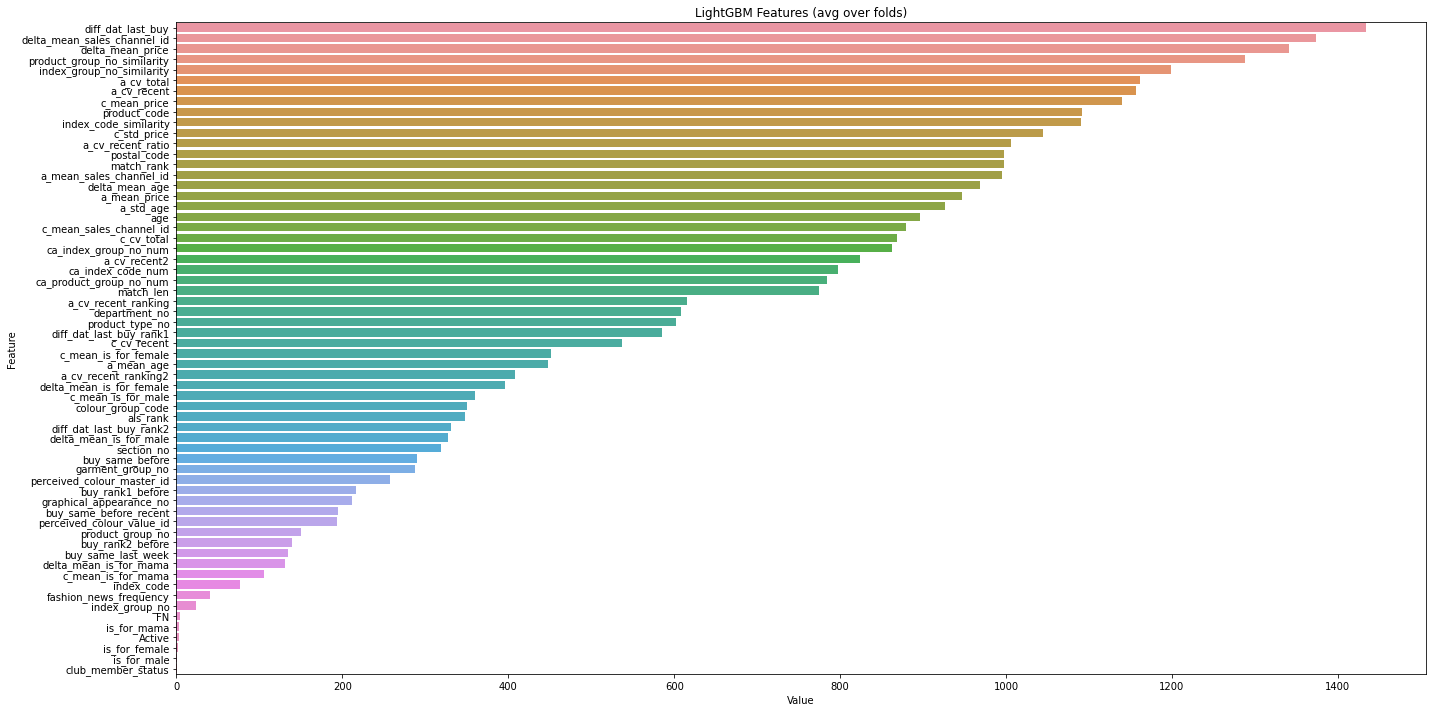

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## test

In [27]:
# メモリ節約
del train, train_x, train_y, valid, valid_x, valid_y
gc.collect()

15154

In [29]:
# test data
#Nval = 12
#test = dd.read_csv(f'./test.csv', dtype=input_type).compute()
test = dd.read_csv(f'./test_2020-09-16.csv', dtype=input_type).compute()
test

,customer_id,match_len,article_id,match_rank,als_rank,FN,Active,club_member_status,fashion_news_frequency,age,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-5449466430634306129,7,749699002,0,99,False,False,0,2,24,...,-0.002726,-9,-0.153320,0.0,0.0,0.0,0,0,999,999
1,-5449466430634306129,7,882899003,1,99,False,False,0,2,24,...,-0.044342,-7,-0.012695,0.0,0.0,0.0,0,0,999,999
2,-5449466430634306129,7,928905001,2,99,False,False,0,2,24,...,0.005157,-9,-0.200195,0.0,0.0,0.0,0,0,999,999
3,-5449466430634306129,7,934128001,3,99,False,False,0,2,24,...,-0.003220,-17,0.000000,0.0,0.0,0.0,0,0,999,999
4,-5449466430634306129,7,749699001,4,99,False,False,0,2,24,...,-0.002802,-9,-0.067383,0.0,0.0,0.0,1,0,7,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113581,-6680722840082728879,4,896169002,25,99,False,False,0,1,50,...,-0.025482,8,-0.374023,0.0,0.0,0.0,0,0,999,999
113582,-6680722840082728879,4,796210001,26,99,False,False,0,1,50,...,-0.000464,10,-0.391602,0.0,0.0,0.0,0,0,999,999
113583,-6680722840082728879,4,783346001,27,99,False,False,0,1,50,...,-0.000640,11,-0.178711,0.0,0.0,0.0,0,0,999,999
113584,-6680722840082728879,4,929165002,28,29,False,False,0,1,50,...,-0.025482,15,0.288086,0.0,0.0,0.0,0,0,999,999


In [30]:
test.sort_index(inplace=True)

In [31]:
test_id = test[['customer_id', 'article_id']]
test = test.drop(['customer_id', 'article_id'], axis=1)

### prediction

In [32]:
del query_list_train, query_list_valid, lgb_train, lgb_eval, params, feature_imp
gc.collect()

0

In [33]:
test

,match_len,match_rank,als_rank,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,7,0,99,False,False,0,2,24,162904,0.021774,...,-0.002726,-9,-0.153320,0.000000,0.000000,0.0,0,0,999,999
0,6,23,99,True,True,0,4,57,203347,0.050842,...,0.009048,18,0.000000,0.000000,0.000000,0.0,0,0,999,999
0,7,18,99,True,True,0,4,32,253122,0.024811,...,0.016724,-3,-0.433594,0.071411,-0.071289,0.0,0,0,999,999
0,7,6,99,False,False,0,2,27,259406,0.022934,...,-0.005741,-3,-0.356445,0.000000,0.000000,0.0,0,1,999,215
0,4,3,99,False,False,0,2,53,163431,0.028259,...,0.015411,18,0.382812,0.000000,0.000000,0.0,0,2,999,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113947,3,18,99,True,True,0,4,56,340214,0.050842,...,0.029663,19,0.706055,0.000000,0.000000,0.0,0,0,999,999
113948,3,19,99,True,True,0,4,56,340214,0.050842,...,0.009377,16,0.228516,0.000000,0.000000,0.0,0,0,999,999
113949,3,20,99,True,True,0,4,56,340214,0.050842,...,0.009048,17,0.000000,0.000000,0.000000,0.0,0,0,999,999
113950,3,21,99,True,True,0,4,56,340214,0.050842,...,0.017639,16,0.287109,0.000000,0.000000,0.0,0,0,999,999


In [34]:
test.columns.values

array(['match_len', 'match_rank', 'als_rank', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age',
       'postal_code', 'c_mean_price', 'c_std_price', 'c_cv_total',
       'c_cv_recent', 'c_mean_sales_channel_id', 'c_mean_is_for_male',
       'c_mean_is_for_female', 'c_mean_is_for_mama', 'diff_dat_last_buy',
       'product_code', 'product_type_no', 'graphical_appearance_no',
       'colour_group_code', 'perceived_colour_value_id',
       'perceived_colour_master_id', 'department_no', 'index_code',
       'index_group_no', 'section_no', 'garment_group_no', 'is_for_male',
       'is_for_female', 'is_for_mama', 'product_group_no', 'a_mean_price',
       'a_cv_total', 'a_cv_recent', 'a_cv_recent2', 'a_cv_recent_ranking',
       'a_cv_recent_ranking2', 'a_cv_recent_ratio',
       'a_mean_sales_channel_id', 'a_mean_age', 'a_std_age',
       'ca_index_group_no_num', 'index_group_no_similarity',
       'ca_index_code_num', 'index_code_similarity',
       'ca_product_

In [35]:
#pred = model.predict(test, num_iteration=200)
pred = model.predict(test, num_iteration=model.best_iteration)
pred.shape, test.shape

((41159400,), (41159400, 62))

In [36]:
del test, model
gc.collect()

4

In [37]:
test_id = test_id.reset_index(drop=True)
pred = pd.Series(pred, name='score')

In [38]:
sub1 = pd.concat([test_id, pred], axis=1)

In [39]:
#sub1 = sub1[['customer_id', 'article_id', 'score']]

In [40]:
sub1

,customer_id,article_id,score
0,-5449466430634306129,749699002,0.478466
1,6049647825016512452,909911001,-0.819801
2,2318960191704685142,717464001,-0.506788
3,603136980095203643,827957002,-1.453420
4,-1233560846016124554,711053005,-0.651948
...,...,...,...
41159395,6583137534785816825,673677002,-0.840286
41159396,6583137534785816825,910601002,-0.404110
41159397,6583137534785816825,909911001,-0.822798
41159398,6583137534785816825,751471038,-0.816506


In [41]:
sub1 = sub1.sort_values(['customer_id','score'], ascending=False)

In [42]:
sub1 = sub1.groupby('customer_id')['article_id'].apply(list).reset_index(name='prediction')

In [43]:
sub1['prediction'].apply(len)

0          30
1          30
2          30
3          30
4          30
           ..
1371975    30
1371976    30
1371977    30
1371978    30
1371979    30
Name: prediction, Length: 1371980, dtype: int64

In [44]:
sub1['prediction'] = sub1['prediction'].apply(lambda x: x[:12])
sub1['prediction'].apply(len)

0          12
1          12
2          12
3          12
4          12
           ..
1371975    12
1371976    12
1371977    12
1371978    12
1371979    12
Name: prediction, Length: 1371980, dtype: int64

In [45]:
sub1['prediction']

0          [706016001, 706016001, 673396002, 706016002, 8...
1          [910601003, 908292002, 903926002, 910601003, 8...
2          [610776002, 918522001, 896152002, 924243001, 6...
3          [448509014, 918292001, 706016001, 562245046, 6...
4          [751471043, 918522001, 751471001, 896152002, 8...
                                 ...                        
1371975    [706016001, 706016003, 751471001, 706016001, 8...
1371976    [658030020, 918292001, 658030011, 715624001, 4...
1371977    [918525001, 924243001, 915529003, 909370001, 8...
1371978    [918522001, 896152002, 751471043, 924243001, 8...
1371979    [781758003, 781758001, 448509014, 918292001, 9...
Name: prediction, Length: 1371980, dtype: object

In [46]:
# 提出用に元に戻す
sub1['prediction'] = sub1['prediction'].map(lambda x:'0'+' 0'.join(map(str, x)))

In [47]:
sub1

,customer_id,prediction
0,-9223352921020755230,0706016001 0706016001 0673396002 0706016002 08...
1,-9223343869995384291,0910601003 0908292002 0903926002 0910601003 08...
2,-9223321797620987725,0610776002 0918522001 0896152002 0924243001 06...
3,-9223319430705797669,0448509014 0918292001 0706016001 0562245046 06...
4,-9223308614576639426,0751471043 0918522001 0751471001 0896152002 08...
...,...,...
1371975,9223319300843860958,0706016001 0706016003 0751471001 0706016001 08...
1371976,9223333063893176977,0658030020 0918292001 0658030011 0715624001 04...
1371977,9223345314868180224,0918525001 0924243001 0915529003 0909370001 08...
1371978,9223357421094039679,0918522001 0896152002 0751471043 0924243001 08...


## Submit

In [48]:
sub = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
del sub['prediction']; gc.collect()
visualize_df(sub)

(1371980, 1)


,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [49]:
sub['customer_id2'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [50]:
print(sub.shape, sub1.shape)

(1371980, 2) (1371980, 2)


In [51]:
sub

,customer_id,customer_id2
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,6883939031699146327
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-7200416642310594310
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-6846340800584936
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-94071612138601410
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-283965518499174310
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,7551062398649767985
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,-9141402131989464905
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,-8286316756823862684
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,2551401172826382186


In [52]:
sub1

,customer_id,prediction
0,-9223352921020755230,0706016001 0706016001 0673396002 0706016002 08...
1,-9223343869995384291,0910601003 0908292002 0903926002 0910601003 08...
2,-9223321797620987725,0610776002 0918522001 0896152002 0924243001 06...
3,-9223319430705797669,0448509014 0918292001 0706016001 0562245046 06...
4,-9223308614576639426,0751471043 0918522001 0751471001 0896152002 08...
...,...,...
1371975,9223319300843860958,0706016001 0706016003 0751471001 0706016001 08...
1371976,9223333063893176977,0658030020 0918292001 0658030011 0715624001 04...
1371977,9223345314868180224,0918525001 0924243001 0915529003 0909370001 08...
1371978,9223357421094039679,0918522001 0896152002 0751471043 0924243001 08...


In [53]:
sub =  pd.merge(sub, sub1, left_on='customer_id2', right_on='customer_id', how='left')
#sub = sub.drop([['customer_id2', 'customer_id_y']], axis=1)

In [54]:
sub = sub[['customer_id_x', 'prediction']].copy()
sub.columns = ['customer_id', 'prediction']
print(sub.shape)

(1371980, 2)


In [55]:
sub

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601006 0858856005 0751471001 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0673677002 0898713001 0863583001 0918522001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0794321011 0805000001 0909370001 08...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0720125001 0918522001 0730683001 0924243001 03...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152001 0896152002 0730683050 0918522001 08...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022 0611415001 0720125039 0804992014 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846008 0706016001 0448509014 0762846006 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0762846027 0762846031 0689365050 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0448509014 0918292001 0706016003 0924243001 07...


In [56]:
#sub = sub[['customer_id', 'valid_pred']].copy()
#sub.columns = ['customer_id', 'prediction']
print(sub.shape)

sub.to_csv('submission.csv', index=False)

(1371980, 2)
